<a href="https://colab.research.google.com/github/mafaves/AI-projects/blob/main/image_dataset/Chest_X-Ray_Images_Pneumonia/chest_x_ray_pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chest X-Ray Images (Pneumonia)

Content
The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

Link to dataset: [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)

In [186]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

import zipfile
import os

#import tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from keras_tuner import BayesianOptimization
from keras_tuner.engine.hyperparameters import HyperParameters
import tensorflow as tf
from tensorflow import keras

import cv2
import PIL

In [42]:
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 4.2 MB/s eta 0:00:00


In [43]:
import keras_tuner

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## DOWNLOADING DATA

In [3]:
#path to the kaggle.json directory
path_API_autentification_token= '/content/drive/MyDrive/Colab_Notebooks/master/Chest_X_Ray_Images_Pneumonia'

In [4]:
# Coping the kaggle API to the Google Colab
os.environ['KAGGLE_CONFIG_DIR'] = path_API_autentification_token

# Downloading the data
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Unzziping the data and storing into /tmp
zip_ref = zipfile.ZipFile('chest-xray-pneumonia.zip', 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

 99% 2.28G/2.29G [00:10<00:00, 326MB/s]
100% 2.29G/2.29G [00:10<00:00, 232MB/s]


In [5]:
# Define the path to the extracted directory
extracted_dir = '/tmp/chest_xray/train/NORMAL'

# List the contents of the directory
contents = os.listdir(extracted_dir)

# Print the contents
#print(contents)

## DATA PREPARATION

The downloaded data contain 3 main folders: 'test', 'val' and 'test'. Inside each one, there are two subcategories: 'NORMAL' and 'PNEUMONIA'.

 In this case, I prefer to only have two: 'NORMAL' and 'PNEUMONIA' (I prefer it in order to manage all images with tf)

In [6]:
import os
import shutil

# Define the path to the extracted directory
extracted_dir = '/tmp/chest_xray'

# Define the paths
main_folders = ['train', 'val', 'test']
output_folders = ['NORMAL', 'PNEUMONIA']

# Iterate through the main folders
for main_folder in main_folders:
    main_path = os.path.join(extracted_dir, main_folder)

    # Iterate through 'normal' and 'pneumonia' folders
    for output_folder in output_folders:
        category_path = os.path.join(main_path, output_folder)

        # Create output folder if it doesn't exist
        output_path = os.path.join(extracted_dir, output_folder)
        if not os.path.exists(output_path):
            os.makedirs(output_path)

        # Iterate through files in the category folder
        for filename in os.listdir(category_path):
            file_path = os.path.join(category_path, filename)

            # Move the file to the combined output folder
            output_file_path = os.path.join(output_path, filename)
            shutil.move(file_path, output_file_path)

In [7]:
# Define the path to the extracted directory
extracted_dir = '/tmp/chest_xray/PNEUMONIA'
# List the contents of the directory
contents = os.listdir(extracted_dir)

# Print the contents
#print(contents)

In [8]:
# Define the path to the extracted directory
extracted_dir = '/tmp/chest_xray'
# Paths to the new main folders
normal_path = os.path.join(extracted_dir, 'NORMAL')
pneumonia_path = os.path.join(extracted_dir,'PNEUMONIA')

# Count the number of files in the 'normal' folder
normal_count = len(os.listdir(normal_path))
print(f"Number of files in 'normal' folder: {normal_count}")

# Count the number of files in the 'pneumonia' folder
pneumonia_count = len(os.listdir(pneumonia_path))
print(f"Number of files in 'pneumonia' folder: {pneumonia_count}")

Number of files in 'normal' folder: 1583
Number of files in 'pneumonia' folder: 4273


Data is imbalanced. There are quite more 'pneumonia' images than 'normal' images. This will have to be taken into account in the subsequent analysis.

In [9]:
# Define paths
tmp_dir = '/tmp/chest_xray'
images_dir = os.path.join(tmp_dir, 'images')

# Create the 'images' folder if it doesn't exist
if not os.path.exists(images_dir):
    os.makedirs(images_dir)

# Move 'NORMAL' and 'PNEUMONIA' folders into the 'images' folder
for folder_name in ['NORMAL', 'PNEUMONIA']:
    src_folder = os.path.join(tmp_dir, folder_name)
    dest_folder = os.path.join(images_dir, folder_name)

    # Move the folder
    shutil.move(src_folder, dest_folder)

print("Folders moved successfully.")

Folders moved successfully.


##EDA

https://www.kaggle.com/code/sardiirfansyah/cnn-augmentation-transfer-learning-top-score-97

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Set the paths to your image folders
normal_folder = '/tmp/chest_xray/images/NORMAL'
pneumonia_folder = '/tmp/chest_xray/images/PNEUMONIA'

# Function to load and plot images from a folder
def plot_images_from_folder(folder, title):
    plt.figure(figsize=(15, 4))
    plt.suptitle(title, fontsize=16)

    for i, file in enumerate(os.listdir(folder)[:5]):  # Displaying only the first 5 images
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        height, width, _ = img.shape  # Get image size
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Image {i + 1}')
        plt.title(f'Image {i + 1}\nSize: {width}x{height}')

    plt.show()

# Function to plot boxplot of image sizes
def plot_image_sizes(folder, title):
    sizes = []

    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path)
        if img is not None:  # Check if image is valid
            sizes.append(img.shape[:2])  # Get width and height

    if sizes:
        sizes = list(zip(*sizes))  # Transpose the list
        plt.figure(figsize=(8, 5))
        plt.boxplot(sizes, labels=['Width', 'Height'])
        plt.title(title)
        plt.ylabel('Image Size')
        plt.show()
    else:
        print(f"No valid images found in {folder}.")

# Function to plot count plot of the number of images in each class
def plot_class_distribution(normal_folder, pneumonia_folder):
    # Count the number of images in each class
    normal_count = len(os.listdir(normal_folder))
    pneumonia_count = len(os.listdir(pneumonia_folder))

    # Calculate proportions
    total_samples = normal_count + pneumonia_count
    normal_proportion = normal_count / total_samples
    pneumonia_proportion = pneumonia_count / total_samples

    # Create a DataFrame for plotting
    data = {'Class': ['NORMAL', 'PNEUMONIA'], 'Proportion': [normal_proportion, pneumonia_proportion]}
    df = pd.DataFrame(data)

    # Plot the class distribution using a barplot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Class', y='Proportion', data=df, palette='Set2', hue='Class', dodge=False, legend=False)

    # Annotate with counts
    for i, count in enumerate([normal_count, pneumonia_count]):
        plt.text(i, count/total_samples, f'{count}\n({count/total_samples:.2%})', ha='center', va='bottom')

    plt.title('Class Distribution with Proportions')
    plt.xlabel('Class')
    plt.ylabel('Proportion')
    plt.ylim(0, 1)  # Ensure the y-axis is between 0 and 1
    plt.show()


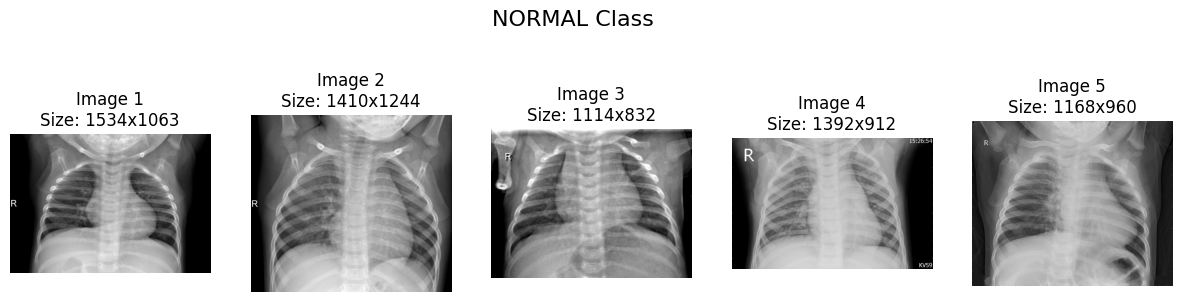

In [ ]:
# Plot images from the NORMAL folder
plot_images_from_folder(normal_folder, 'NORMAL Class')

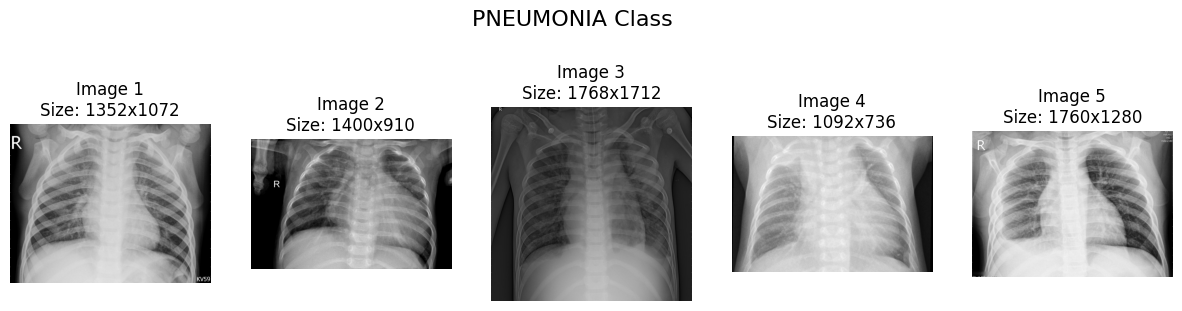

In [ ]:
# Plot images from the PNEUMONIA folder
plot_images_from_folder(pneumonia_folder, 'PNEUMONIA Class')


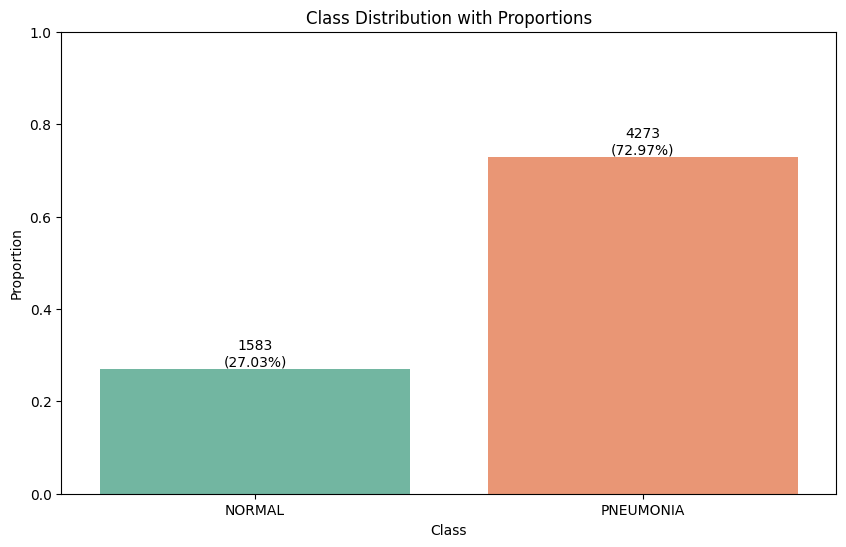

In [ ]:
# Plot count plot of class distribution
plot_class_distribution(normal_folder, pneumonia_folder)

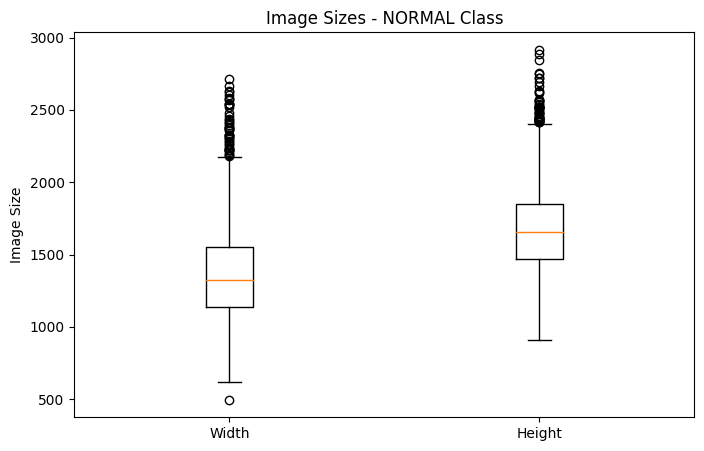

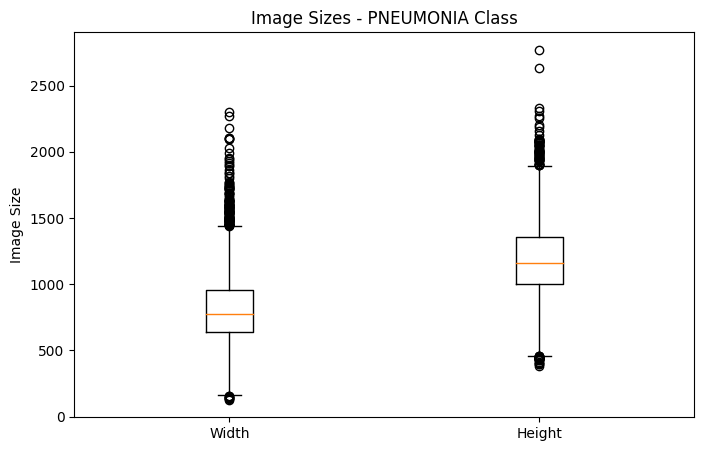

In [ ]:
# Plot boxplot of image sizes for each class
plot_image_sizes(normal_folder, 'Image Sizes - NORMAL Class')
plot_image_sizes(pneumonia_folder, 'Image Sizes - PNEUMONIA Class')

## PREPROCESSING IMAGES

In [10]:
# Define the path to the extracted directory
extracted_dir = '/tmp/chest_xray/images'
# List the contents of the directory
contents = os.listdir(extracted_dir)

# Print the contents
print(contents)

['NORMAL', 'PNEUMONIA']


In [11]:
#Define image sizes
BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS=1
EPOCHS=10

#### LOAD DATASET

In [12]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/tmp/chest_xray/images',
    color_mode = 'grayscale',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5856 files belonging to 2 classes.


In [13]:
# Get the number of batches in the dataset
num_batches = tf.data.experimental.cardinality(dataset).numpy()
print("Number of batches:", num_batches)

Number of batches: 183


In [14]:
# Print the first batch of data
for images, labels in dataset.take(1):
    print("Batch of images shape:", images.shape)
    print("Batch of labels shape:", labels.shape)
    print("Example labels:", labels.numpy())

Batch of images shape: (32, 128, 128, 1)
Batch of labels shape: (32,)
Example labels: [1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 0 1 0 0 1 1 0]


In [15]:
class_names = dataset.class_names
class_names

['NORMAL', 'PNEUMONIA']

### Visualize some of the images from our dataset

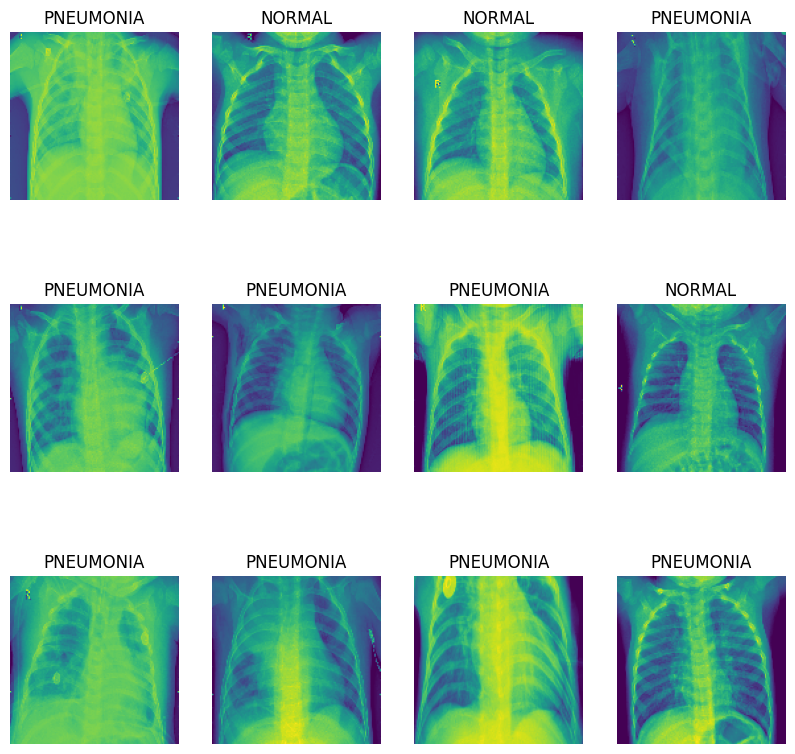

In [16]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

146

In [20]:
len(val_ds)

18

In [21]:
len(test_ds)

19

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

* **.cache():** Caching is used to keep the dataset in memory after it's loaded from disk. This can significantly speed up training by avoiding redundant reading and preprocessing of data in each epoch. The first time the dataset is iterated over, it will be cached in memory, and subsequent iterations will use the cached data.

* **.shuffle(1000):** This performs a random shuffle of the dataset with a buffer size of 1000. Shuffling is essential during training to ensure that the model sees a diverse set of examples in each batch. The buffer size determines the number of elements from the dataset that are randomly sampled to fill the buffer. Larger buffer sizes provide better shuffling but require more memory.

* **.prefetch(buffer_size=tf.data.AUTOTUNE):** Prefetching is used to overlap data preprocessing and model training. It helps to speed up training by fetching batches in the background while the model is being trained on the current batch. The buffer_size parameter determines how many batches to prefetch. Setting it to tf.data.AUTOTUNE allows TensorFlow to dynamically adjust the prefetch buffer size based on available system resources.


# BUILDING THE MODEL

Creating a Layer for Resizing and Normalization

In [23]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

##DATA AUMENTATION

###Applying Data Augmentation to Train Dataset

Data augmentation is commonly used in the field of medical imaging, including X-ray images, to increase the diversity of the training dataset and improve the generalization of deep learning models. The choice of data augmentation techniques depends on the characteristics of the data and the specific task you are addressing. Here are some commonly used data augmentation techniques for X-ray images:

* **Rotation**: Randomly rotate the X-ray images by a small angle (e.g., 5-15 degrees). This can help the model become invariant to different orientations.

* **Horizontal and Vertical Flipping**: Apply random horizontal and vertical flips. This can simulate variations in patient positioning during imaging.

* **Zooming**: Randomly zoom in or out on the X-ray images. This can help the model learn to focus on specific regions of interest.

* **Brightness and Contrast Adjustment**: Adjust the brightness and contrast of the X-ray images. This can simulate variations in image quality due to different imaging conditions.

* **Gaussian Noise**: Add random Gaussian noise to the images. This can simulate noise in real-world imaging conditions.

* **Elastic Transformations**: Apply elastic deformations to the images. This technique introduces local distortions, which can be useful for handling variations in organ shapes.

* **Histogram Equalization**: Perform histogram equalization to enhance the contrast of the X-ray images. This can be useful for improving visibility of certain structures.

* **Crop and Resize**: Randomly crop and resize the X-ray images. This can help the model learn to focus on different regions of the image.



When applying data augmentation to medical images, it's essential to consider the medical context and consult with domain experts. Additionally, it's crucial to validate the effectiveness of the chosen augmentation strategies through careful evaluation on a validation set. Also, be cautious about introducing unrealistic variations that may not be representative of the actual clinical scenarios.

Remember that the effectiveness of data augmentation may vary depending on the specific dataset and task, so it's often a good idea to experiment with different combinations of augmentations and monitor the model's performance.



[Link](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing)
```
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(20),
  layers.experimental.preprocessing.RandomZoom(0.2),
  layers.experimental.preprocessing.RandomContrast(0.1),
  ...
])
```



In [24]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


There are two ways:

1. Outside the model architecture, so then we pass the train_ds with augmented images. In this case, the preprocessing layers will not be exported with the model when you call Model.save.

2. Inside the model architecture, creating a layer of data augmentation. The data augmentation will run on the device, synchronously with the rest of your layers, and will benefit from GPU acceleration.

When you export your model using model.save , the pre-processing layers will be saved along with the rest of your model.

The map function is used to apply a custom function to each element of the dataset. In this case, it's a lambda function that takes each (x, y) pair (where x is an input data element and y is its corresponding label) and applies data augmentation to x using the data_augmentation function.
The training=True argument is typically used to signal the data augmentation function whether it should apply certain augmentations that are only relevant during training (as opposed to inference).

#### Way 1

In [25]:
train_ds_augmented = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
len(train_ds)

146

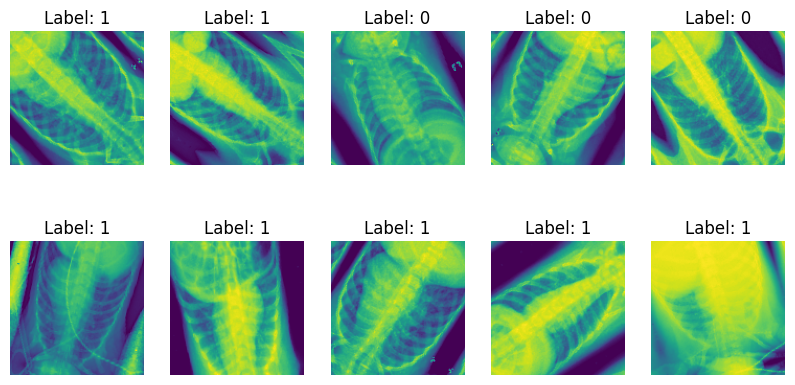

In [27]:
import matplotlib.pyplot as plt

# Assuming you have the augmented training dataset (train_ds)
# and you want to visualize 110 images from the first batch
sample_size = 10

# Take the first batch from the augmented dataset
first_batch = train_ds_augmented.take(1)

# Visualize the specified number of images from the first batch
plt.figure(figsize=(10, 5))

for i, (images, labels) in enumerate(first_batch):
    for j in range(min(sample_size, len(images))):
        plt.subplot(2, 5, j + 1)
        plt.imshow(images[j].numpy().astype("uint8"))
        plt.title(f"Label: {labels[j].numpy()}")
        plt.axis("off")

plt.show()

##### Padding
Padding is a technique used in convolutional neural networks (CNNs) to preserve the spatial dimensions of the input volume. In a convolutional layer, the filter moves across the input image, and without padding, the spatial dimensions of the output volume gradually decrease. Padding involves adding extra pixels around the input image, allowing the convolutional layer to retain more information about the input's spatial dimensions.

There are two common types of padding:

1. Valid (No Padding): In this type, no padding is added to the input. As the filter moves across the input image, it stays completely within the bounds of the input. This results in a smaller output size compared to the input.

2. Same (Zero Padding): In this type, padding is added evenly to all sides of the input so that the filter can scan the entire input. The amount of padding is chosen such that the output size is the same as the input size when using a stride of 1.

##### Dropout
Dropout is a regularization technique used to prevent overfitting in neural networks. During training, random units (neurons) are dropped out or set to zero, meaning they do not contribute to the forward pass or backward pass. This helps prevent the model from relying too heavily on specific neurons and improves generalization.

## KERAS-TUNNING

[Information link](https://keras.io/api/keras_tuner/)

In [44]:
print(tf.__version__)

2.15.0


In [187]:
def build_model(hp):

  model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        padding = 'same',
        input_shape = (128,128,1),
    ),
    layers.MaxPooling2D(
        pool_size= hp.Choice('Max_pooling_1', values = [2,4])
        ),
    layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=8),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu',
        padding = 'same',
    ),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=32, max_value=64, step=8),
        kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
        activation='relu',
        padding = 'same',
    ),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(
        filters=hp.Int('conv_4_filter', min_value=32, max_value=64, step=8),
        kernel_size=hp.Choice('conv_4_kernel', values = [3,5]),
        activation='relu',
        padding = 'same',
    ),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=144, step=16),
        activation='relu'
    ),
    # Add Dropout layer with a dropout rate of 0.2
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid'),
  ])

  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='binary_crossentropy',
              metrics=['accuracy'])

  return model

In [154]:
keras.backend.clear_session()
tuner_search_3 = BayesianOptimization(build_model,
                          objective='val_accuracy',
                          max_trials=10,
                          seed=123,
                          directory='/tmp/chest_xray/',
                          project_name="x_ray_chest_tuner_2")

In [155]:
tuner_search_3.search(train_ds_augmented,epochs=5,validation_data=val_ds)

Trial 10 Complete [00h 00m 43s]
val_accuracy: 0.8055555820465088

Best val_accuracy So Far: 0.9184027910232544
Total elapsed time: 00h 06m 12s


In [159]:
tuner_search_3.results_summary()

Results summary
Results in /tmp/chest_xray/x_ray_chest_tuner_2
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 05 summary
Hyperparameters:
conv_1_filter: 128
conv_1_kernel: 5
Max_pooling_1: 2
conv_2_filter: 48
conv_2_kernel: 3
conv_3_filter: 32
conv_3_kernel: 3
conv_4_filter: 64
conv_4_kernel: 3
dense_1_units: 64
learning_rate: 0.001
Score: 0.9184027910232544

Trial 02 summary
Hyperparameters:
conv_1_filter: 128
conv_1_kernel: 3
Max_pooling_1: 4
conv_2_filter: 48
conv_2_kernel: 3
conv_3_filter: 64
conv_3_kernel: 5
conv_4_filter: 64
conv_4_kernel: 5
dense_1_units: 48
learning_rate: 0.001
Score: 0.9166666865348816

Trial 04 summary
Hyperparameters:
conv_1_filter: 48
conv_1_kernel: 5
Max_pooling_1: 2
conv_2_filter: 56
conv_2_kernel: 5
conv_3_filter: 40
conv_3_kernel: 3
conv_4_filter: 64
conv_4_kernel: 3
dense_1_units: 32
learning_rate: 0.001
Score: 0.9027777910232544

Trial 07 summary
Hyperparameters:
conv_1_filter: 32
conv_1_kernel: 3
Max_pooling_1: 4
conv_2

In [188]:
# Define the path to the extracted directory
extracted_dir = '/tmp/chest_xray/x_ray_chest_tuner_2/'

# List the contents of the directory
contents = os.listdir(extracted_dir)
#contents

In [156]:
model4=tuner_search_3.get_best_models(num_models=1)[0]

In [157]:
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     3328      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 48)        55344     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 48)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        13856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 32)        0

In [160]:
history = model4.fit(
    train_ds_augmented,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/20
146/146 [==============================] - 9s 40ms/step - loss: 0.2396 - accuracy: 0.9048 - val_loss: 0.2125 - val_accuracy: 0.8993
Epoch 2/20
146/146 [==============================] - 5s 35ms/step - loss: 0.2474 - accuracy: 0.9009 - val_loss: 0.2092 - val_accuracy: 0.9045
Epoch 3/20
146/146 [==============================] - 5s 34ms/step - loss: 0.2345 - accuracy: 0.9045 - val_loss: 0.1735 - val_accuracy: 0.9288
Epoch 4/20
146/146 [==============================] - 6s 42ms/step - loss: 0.2280 - accuracy: 0.9101 - val_loss: 0.1923 - val_accuracy: 0.9201
Epoch 5/20
146/146 [==============================] - 6s 43ms/step - loss: 0.2286 - accuracy: 0.9073 - val_loss: 0.1741 - val_accuracy: 0.9132
Epoch 6/20
146/146 [==============================] - 7s 47ms/step - loss: 0.2256 - accuracy: 0.9118 - val_loss: 0.2074 - val_accuracy: 0.9132
Epoch 7/20
146/146 [==============================] - 6s 42ms/step - loss: 0.2191 - accuracy: 0.9146 - val_loss: 0.1650 - val_accuracy: 0.9427

In [161]:
scores = model4.evaluate(test_ds)

19/19 [==============================] - 0s 13ms/step - loss: 0.1947 - accuracy: 0.9359


In [162]:
scores

[0.1946689784526825, 0.9358552694320679]

In [163]:
history

In [164]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

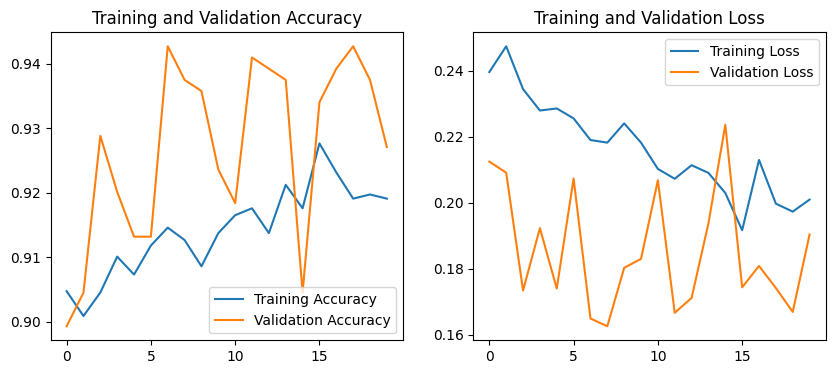

In [169]:
EPOCHS = EPOCHS
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### PREDICTIONS

In [170]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    raw_prediction = predictions[0][0]
    predicted_class = class_names[round(raw_prediction)]

    return predicted_class, raw_prediction

1/1 [==============================] - 0s 27ms/step


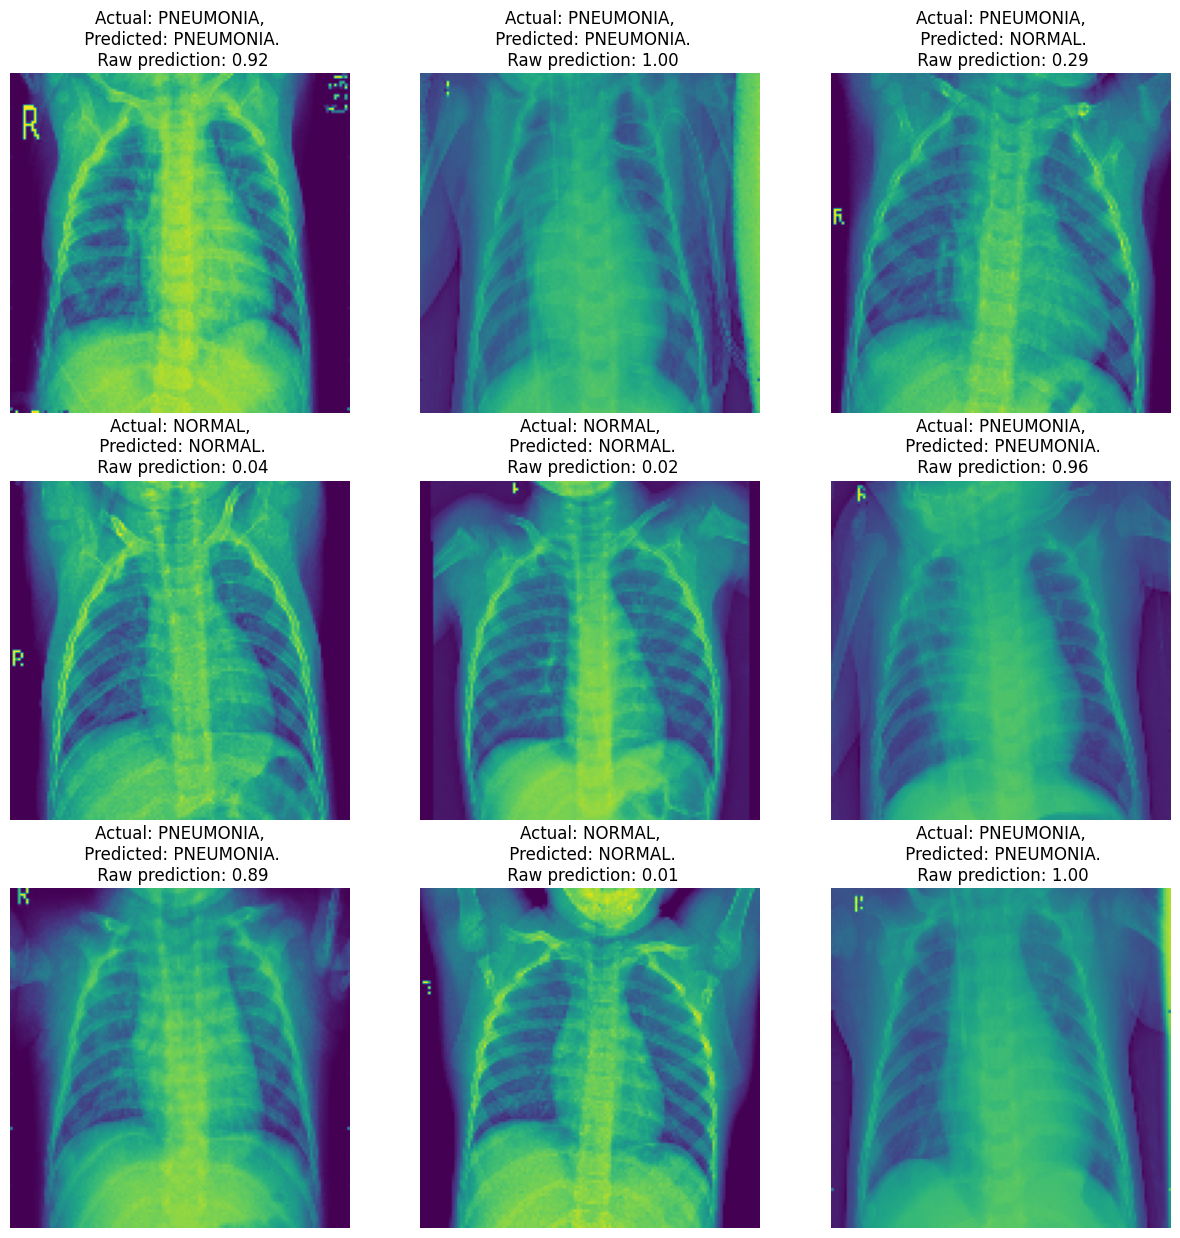

In [171]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, raw_prediction = predict(model4, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Raw prediction: {raw_prediction:.2f}")

        plt.axis("off")

#### Classification report

In [176]:
# Make sure you haven't overwritten the classification_report function
from sklearn.metrics import classification_report

In [177]:
# Mendefinisikan fungsi untuk membuat prediksi
def predict_and_evaluate(model, dataset):
    y_true = []  # Label yang sebenarnya
    y_pred = []  # Label hasil prediksi

    # Iterasi melalui dataset untuk mendapatkan label sebenarnya dan hasil prediksi
    for image, label in dataset:
        predictions = model.predict(image,verbose=0)
        y_true.extend(label.numpy())
        y_pred.extend(np.round(predictions).flatten())

    # Menghasilkan classification report
    report = classification_report(y_true, y_pred, target_names=['normal', 'pneumonia'])

    return report

In [178]:
# Membuat classification report
classification_report = predict_and_evaluate(model4, test_ds)

# Menampilkan classification report
print(classification_report)

              precision    recall  f1-score   support

      normal       0.87      0.90      0.88       167
   pneumonia       0.96      0.95      0.96       441

    accuracy                           0.94       608
   macro avg       0.92      0.92      0.92       608
weighted avg       0.94      0.94      0.94       608



#### Confusion matrix

In [179]:
def calculate_confusion_matrix(model, dataset):
    y_true = []  # Label yang sebenarnya
    y_pred = []  # Label hasil prediksi

    # Iterasi melalui dataset untuk mendapatkan label sebenarnya dan hasil prediksi
    for image, label in dataset:
        predictions = model.predict(image,verbose=0)
        y_true.extend(label.numpy())
        y_pred.extend(np.round(predictions).flatten())

    # Menghitung confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    #Plot confusion_matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Normal', 'Pneumonia'],
                yticklabels=['Normal', 'Pneumonia'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Ekstraksi TP, FP, TN, FN
    #gunakan ravel() atau flatten() untuk mendapatkan array satu dimensi
    tn, fp, fn, tp = conf_matrix.ravel()
    #tp = conf_matrix[1, 1]
    #p = conf_matrix[0, 1]
    #tn = conf_matrix[0, 0]
    #fn = conf_matrix[1, 0]

    return tp, fp, tn, fn

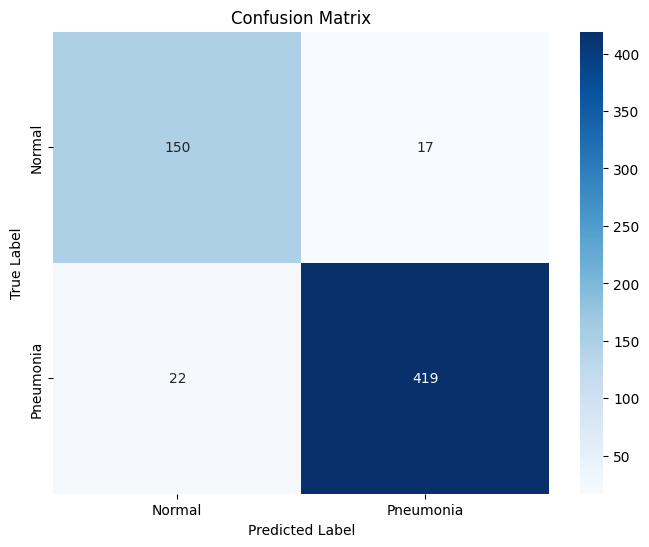

True Positive (TP): 419
False Positive (FP): 17
True Negative (TN): 150
False Negative (FN): 22


In [180]:
# Menghitung confusion matrix dari model terload dan dataset test
tp, fp, tn, fn = calculate_confusion_matrix(model4, test_ds)

# Menampilkan hasil
print("True Positive (TP):", tp)
print("False Positive (FP):", fp)
print("True Negative (TN):", tn)
print("False Negative (FN):", fn)

### SAVING THE MODEL

In [181]:
model4.save('/tmp/chest_xray/images/output-pneumonia.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [182]:
# Define the path to the extracted directory
extracted_dir = '/tmp/chest_xray/images'

# List the contents of the directory
contents = os.listdir(extracted_dir)

# Print the contents
print(contents)

['output-pneumonia.h5', 'NORMAL', 'PNEUMONIA']


In [28]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    #data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', padding='same', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32,  kernel_size = (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    # Add Dropout layer with a dropout rate of 0.2
    layers.Dropout(0.2),
    # Output layer for binary classification
    layers.Dense(1, activation='sigmoid'),
])

model.build(input_shape=input_shape)

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 128, 128, 1)         0         
                                                                 
 conv2d (Conv2D)             (32, 128, 128, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (32, 64, 64, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 64, 64, 32)          9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 32, 32, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 32, 32, 64)         

In [30]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)